# Markov chain Monte Carlo–based Bayesian data analysis for type Ia Supernovae 

Author: Olesya Galkina

Markov chain Monte Carlo (MCMC) and Bayesian statistics are two independent disciplines, the former being a method to sample from a distribution while the latter is a theory to interpret observed data.

In [44]:
import pandas as pd
import numpy as np
import math

# For data visualization
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import constants

# For analysing Monte Carlo samples
import emcee
from emcee import EnsembleSampler

# For plotting Monte Carlo samples
import getdist
from getdist import plots

In this work we use the latest data from the Pantheon+SH0ES collaboration that provides $1701$ light curve measurements of $1550$ Supernova objects. The data set is available [here](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main).

In [45]:
# Load the data

file_path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES.dat"
df = pd.read_csv(file_path, delimiter='\s+')

df.shape

(1701, 47)

In [46]:
df.head(10)

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006
5,1981B,50,0.00317,0.00084,0.00350,0.00001,0.00236,0.00001,11.54160,0.613941,...,0.2973,41,43.2260,0.376420,0.0732,0.5763,0.0206,0.007,1.0,0.013
6,2013aa,56,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.20740,0.594070,...,0.1580,31,27.5263,0.645500,0.1104,0.5586,0.0298,0.003,1.0,0.003
7,2013aa,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.29980,0.579622,...,0.1190,56,35.0505,0.987280,0.0620,0.5586,0.0727,0.007,1.0,0.003
8,2017cbv,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.14830,0.577815,...,0.0381,94,69.7345,0.971300,0.0580,0.5586,0.0516,0.004,1.0,0.003
9,2017cbv,18,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.25770,0.577916,...,0.0500,92,45.1690,0.999990,0.0607,0.5586,0.0216,0.003,1.0,0.003


We are interested in following parameters:

 - `df['zCMB']` CMB Corrected Redshift.
 - `df['zCMBERR']` CMB Corrected Redshift Uncertainty.
 - `df['m_b_corr']` corrected/standardized m_b magnitude.
 - `df['m_b_corr_err_DIAG']` corrected/standardized m_b magnitude uncertainty as determined from the diagonal of the covariance matrix. 

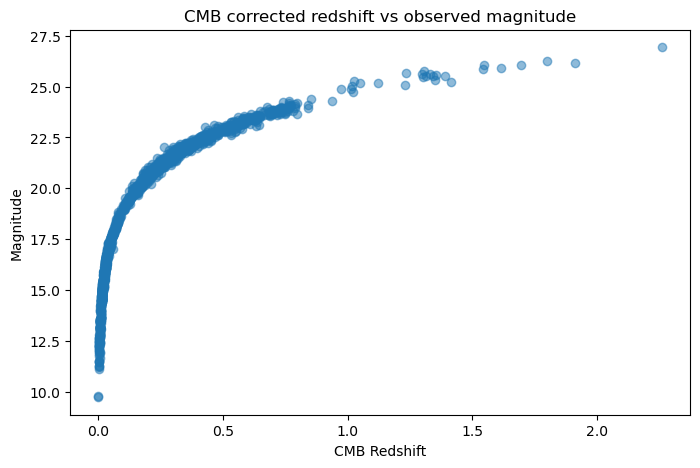

In [47]:
# Plot observed CMB corrected redshift vs observed magnitude

plt.figure(figsize=(8, 5))
plt.scatter(df['zCMB'], df['m_b_corr'], alpha=0.5)
plt.title('CMB corrected redshift vs observed magnitude')
plt.xlabel('CMB Redshift')
plt.ylabel('Magnitude')
plt.grid(False)

plt.show()

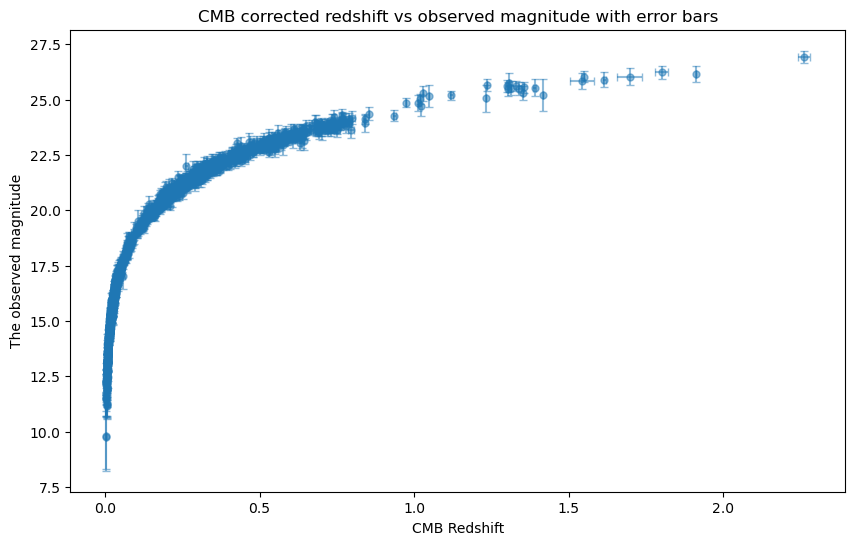

In [48]:
# Plot with error bars

plt.figure(figsize=(10, 6))
plt.errorbar(df['zCMB'], df['m_b_corr'], xerr=df['zCMBERR'], yerr=df['m_b_corr_err_DIAG'], fmt='o', alpha=0.5,
             capsize=3, markersize=5)
plt.title('CMB corrected redshift vs observed magnitude with error bars')
plt.xlabel('CMB Redshift')
plt.ylabel('The observed magnitude')
plt.grid(False)

plt.show()

### The luminosity distance

The luminosity distance is a very important notion of distance for observation. It is based on the knowledge of the intrinsic luminosity _L_ of a source, which is therefore called _standard candle_. Type Ia supernovae are standard candles, for example.


The luminosity distance in a flat expanding Friedmann-Lemaitre-Robertson-Walker universe is defined as:

$$
d_{L}(z)=\frac{c}{H_0}\left[z+\frac{1}{2}(1-q_0)z^2-\frac{1}{6}(3q_0^2+q_0-j_0-1)(z^3)\right], 
$$

where $H_0$ is the Hubble constant, $q_0$ is a deceleration parameter and $j_0$ is a "jerk parameter" (third order derivative parameter).

Let's calculate the luminosity distance (up to second order) assuming the value of the Hubble constant $H_0$ as measured by the _SH0ES_ collaboration and the following parameters:

We use NumPy to perform vectorized operations and avoid using explicit loops.

In [49]:
# Transform df['m_b_corr'] and df["zCMB"] and  to NumPy array

m_data = df['m_b_corr'].to_numpy()
z_values = df["zCMB"].to_numpy()
print(m_data.shape)
print(z_values.shape)

(1701,)
(1701,)


In [50]:
# Function to calculate the luminosity distance d_L
cc = constants.c/1000.

def lum_distance(z,H0,q0,j0):
    dL = cc*z*(1+(1-q0)*(z/2)+(3*q0**2+q0-j0-1)*((z**2)/6))/H0
    return dL

Now, having calculated the luminosity distance, we proceed to visualize it by plotting with a logarithmic scale on the y-axis, utilizing the `matplotlib`'s `semilogy` function. We fix $H_0$, $q_0$ e $j_0$.

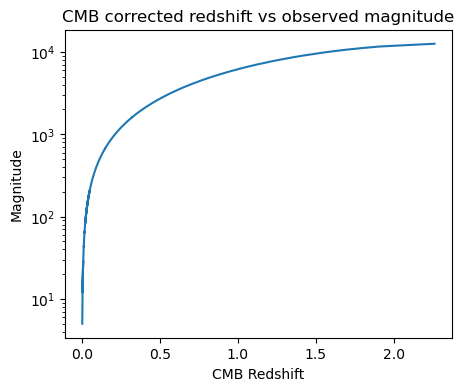

In [51]:
# Plot CMB redshift vs luminosity distance 

plt.figure(figsize=(5, 4))
plt.semilogy(z_values, lum_distance(z_values,73,-0.55,1))
plt.title('CMB corrected redshift vs observed magnitude')
plt.xlabel('CMB Redshift')
plt.ylabel('Magnitude')
plt.grid(False)

plt.show()

### The apparent magnitude

The apparent magnitude $m_B$ of a supernova at redshift $z$ is defined as:

$$
m_B=5\log_{10}\left(\frac{d_{L}(z)}{1 Mpc}\right)+25+M_B,
$$

where $M_B=-19.3$ is the absolute magnitude (the hypothetical apparent magnitude of an object as if it were at a distance of 10 pc). We use the Megaparsec (Mpc) as a more appropriate distance scale for cosmology.

In [52]:
# Function to calculate the magnitude m_B
M_B = -19.3 # Fixing M_B

def magnitude(z, H0, q0, j0):
    lum_dist = lum_distance(z, H0, q0, j0)
    m_B = 5 * np.log10(lum_dist) + 25 + M_B
    return m_B

Now we have theoretical apparent magnitude values that allow us to compare them with the observed ones. 

Text(0, 0.5, 'Theoretical apparent magnitude')

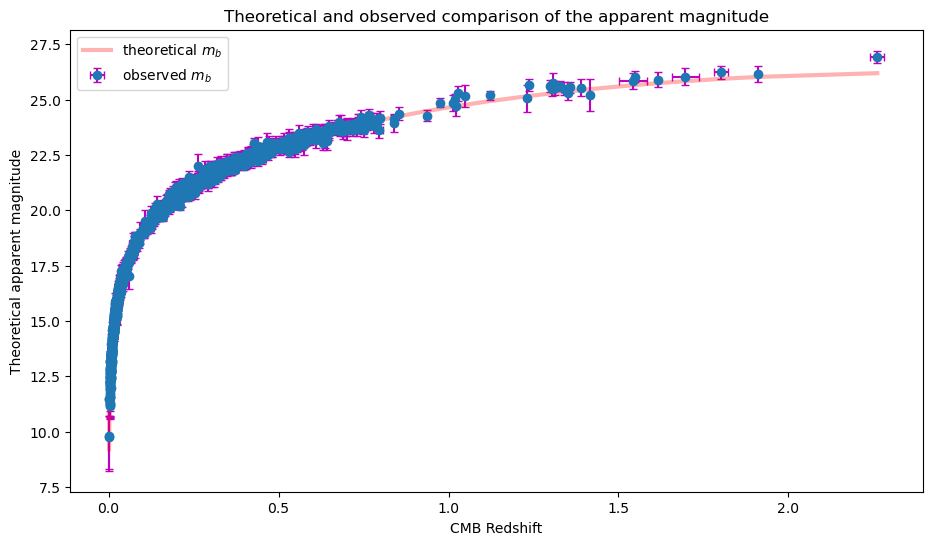

In [53]:
# Theoretical-observed comparison plot of the apparent magnitude

plt.figure(figsize=(11,6))

plt.errorbar(df['zCMB'], df['m_b_corr'], xerr=df['zCMBERR'], yerr=df['m_b_corr_err_DIAG'], fmt='o', ecolor='m', capsize=3)
# Plot the true line
plt.plot(z_values, magnitude(z_values,73,-0.55,1), "r", alpha=0.3, lw=3)
plt.title("Theoretical and observed comparison of the apparent magnitude")
legend = ("theoretical $m_b$","observed $m_b$")
plt.legend(legend)
plt.xlabel('CMB Redshift')
plt.ylabel('Theoretical apparent magnitude')
#plt.savefig('magnitude.png')

### Chi-square $\chi^2$ statistic


The $\chi^2$ function defined as

$$
\chi^2_{sne}(H_0,q_0,j_0)=\left[\mu_{i,data}-\mu_{model}(z_i)\right]\Sigma^{-1}_{sne,ij}\left[\mu_{j,data}-\mu_{model}(z_j)\right],
$$

where $\mu_{i,data}$ and $\mu_{model}(z_i)$ are the _observed_ and _predicted_ distance moduli at the redshift $z_i$, respectively; $\Sigma^{-1}_{sne,ij}$ is the supernova covariance matrix from the Pantheon+ SH0ES collaboration (considering both statistical and systematic errors). First, we explore the covariance matrix.

### Covariance matrix

The format of the covariance (.cov) file is NxN lines, where the first line gives the number of rows/columns in the matrix ($N=1701$). We are interested in the Statistical+Systematic covariance matrix `STAT+SYS`, it includes all the covariance between SNe (and also Cepheid host covariance) due to systematic uncertainties. Let's import the matrix and transform it into a Numpy array format.

In [54]:
# Load the covariant matrix

path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES_STAT+SYS.cov"
cov_matrix = np.loadtxt(path)
n_sne = int(cov_matrix[0])
cov_matrix = cov_matrix[1:].reshape((n_sne, n_sne))

In [55]:
cov_matrix.shape

(1701, 1701)

### Likelihood

Through the $\chi^2$ we define the likelihood:

$$
\mathcal{L}_{sne}(H_0,q_0,j_0)=\mathcal{N}e^{-\frac{1}{2}\chi^{2}},
$$

where $\mathcal{N}=|2\pi\Sigma_{sne}|^{-\frac{1}{2}}$ is a normalization constant. The likelihood represents the probability of having a dataset given a cosmological model. We are interested in the contrary, i.e.
in the probability of having a certain cosmological model given a dataset. This is called **posterior probability**. 

Let's compute the Gaussian log-likelihood for the _observed_ and _predicted_ apparent magnitude at the redshift $z_i$, respectively. For now, we omit the normalization constant.

In [56]:
# Calculate the inverse of the covariance matrix  

cov_inv = np.linalg.inv(cov_matrix)

In [57]:
# Function to compute the logarithm of the likelihood
# Input: vector of parameters H0, parameters q_0 and j_0
# Output: the value of the likelihood at the specified parameter values

def log_likelihood(parameters):
    H0, q0, j0 = parameters
    m_modelo = magnitude(z_values, H0, q0, j0) #Calculate model magnitudes for observed data
    diff = m_data - m_modelo #residuals
    diff = np.array(diff)
    log_likelihood_values = -0.5 * np.dot(diff, np.dot(diff, cov_inv))
    
    return log_likelihood_values

In [58]:
# Check the function

parameters = [73,-0.55,1]
log_likelihood(parameters)

-1094.2658543794344

In [59]:
# Fix the parameters q_0, j_0, H_0

q0_fix = -0.55
j0_fix = 1.

H0_range = np.linspace(65,85,25)
#log_likelihood = np.vectorize(log_likelihood)

### Posterior probability 

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo (MCMC) method. MCMC is a method for fitting models to data. 

According to Bayes Theorem, the posterior probability is given by

$$ 
P(\theta|d) = \frac{P(d|\theta)P(\theta)}{P(d)}, 
$$

where:
- $\theta$ is the cosmological parameters and  $d$ is the observed data, or samples. 
- $P(\theta|d)$ is the posterior probability for $\theta$, and it represents our degree of belief about the value of $\theta$ after we have seen the data $d$. 
- $P(d|\theta)=\mathcal{L}(\theta)$ is the likelihood function we already encountered. It is the probability of the data given a certain value of the parameters.
- $P(\theta)$ is the prior probability distribution. It represents our degree of belief in the value of $\theta$ before we see the data (hence the name).
- $P(d)$ is a normalizing constant, or the evidence, it ensures that the posterior is normalized to unity:$$ P(d)=\int d \theta P(d|\theta)P(\theta).$$


In our case, the posterior probability for $H_0$, $q_0$ and $j_0$ is given by
$$ 
P(H_0,q_0,j_0|SN) = \frac{P(H_0)P(q_0)P(j_0)\mathcal{L}((H_0,q_0,j_0))}{\mathcal{E}}, 
$$

where $\mathcal{E}$ is the evidence.

From now on, we use logarithm of probabilities to compute the log of posterior probability.

The log-prior probability is assumed to be zero if all the parameters are within their bounds and $-\infty$ if any of the parameters are outside their bounds.

In [60]:
# Compute the logarithm of the prior probability
# Input: H0 vector of parameters
# Output: the value of the prior at the specified parameter values

def log_uniprior(parameters):
    H0, q0, j0 = parameters
    if 65 < H0 < 85 and -10 < q0 < 10 and -20 < j0 < 20:
        return 0.0
    return -np.infty

In [61]:
parameters = [73,-0.55,1]
log_uniprior(parameters)

0.0

The posterior distribution combines the prior and the likelihood. It outputs negative infinity if the parameters lie outside the range of the prior.

In [62]:
# Compute log_posterior 
# Input: vector of parameters H0, parameters q_0 and j_0
# Output: the value of the posterior at the specified parameter values

def log_posterior(parameters):
    H0, q0, j0 = parameters
    lu = log_uniprior(parameters)
    if not np.isfinite(lu):
        return -np.inf
    return log_likelihood(parameters) + lu

In [63]:
parameters = [73,-0.55,1]
log_posterior(parameters)

-1094.2658543794344

The purpose of a Markov chain Monte Carlo algorithm is to construct a sequence of points (or “samples”) in parameter space (called “a chain”). The crucial property of the chain is that the density of samples is proportional to the posterior pdf. This allows to construct a map of the posterior distribution.

To sample the posterior we use `emcee`, an open-source sampler for MCMC, and for analyzing the chains we use `getdist`. `emcee` requires a function that returns the log-posterior probability.

First, we define two key variables: `ndim` and `nwalkers`. The `nwalkers` variable is the number of "walkers" (different Markov Chains that run in parallel). 

In [65]:
# Set initial parameters
initial_parameters = [73.04, q0_fix, j0_fix]  

nwalkers = 10
nsteps = 20000

# Generate initial values for each walker
initial_positions = [initial_parameters + 1e-4*np.random.randn(3) for _ in range(nwalkers)]

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, len(initial_parameters), log_posterior)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

# Get Markov chains
samples = sampler.get_chain()

# Print the results
print("Samples shape:", samples.shape)


100%|██████████| 20000/20000 [13:09<00:00, 25.34it/s]

Samples shape: (20000, 10, 3)


Removed no burn in


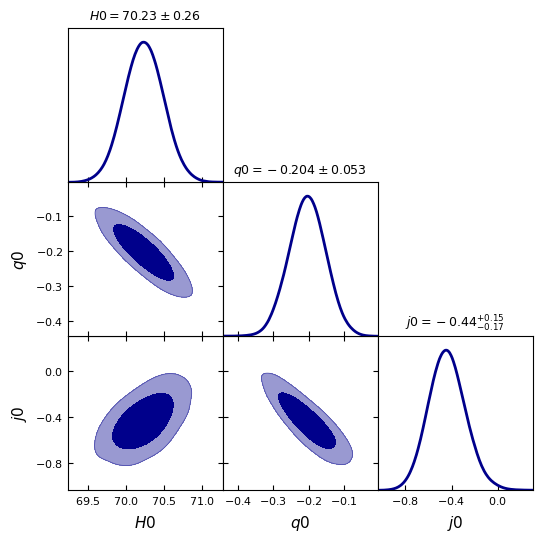

<Figure size 640x480 with 0 Axes>

In [66]:
# Get the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True) 

# Set labels for parameters
param_names = ['H0','q0','j0']

# Create an MCSamples object with the samples
mcsamples = getdist.MCSamples(samples=samples, names=param_names, labels=param_names)

# Plot the triplot
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 12
g.triangle_plot(mcsamples, filled=True, line_args=[{'lw':2, 'color':'darkblue'}], 
                contour_colors=['darkblue'], title_limit=1)

plt.show()
plt.savefig('triplot.png')

## References

[1] D. Scolnic, D. Brout, A. Carr, A. G. Riess, T. M. Davis, A. Dwomoh, D. O. Jones, N. Ali, P. Charvu and R. Chen, et al. _The Pantheon+ Analysis: The Full Data Set and Light-curve Release_, Astrophys. J. 938 (2022).

[1] David Camarena and Valerio Marra, _Local determination of the Hubble constant and the deceleration parameter_, Phys. Rev. Research 2, 013028 (2020).


[2] Oliver Piattella, _Lecture Notes in Cosmology_, Springer Cham (2018). 


[3] D. Foreman-Mackey, D. W. Hogg, D. Lang, and J. Goodman, _emcee: The MCMC Hammer_, Publ. Astron. Soc. Pac. 125 (2013) 306–312, https://arxiv.org/abs/1202.3665


[4] A. Lewis, _GetDist: a Python package for analysing Monte Carlo samples_, arXiv:1910.13970, https://getdist.readthedocs.io.